In [1]:
import os
import time
import random

import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import timm
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchsummary import summary
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

/data/ephemeral/home/cv01/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [3]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = 'datasets_fin/'

# model config
model_name = 'resnet50'

# training config
# img_size = 32
img_size = 100
LR = 1e-3
EPOCHS = 5
BATCH_SIZE = 32
num_workers = 0

# 1. Data Load

In [4]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

# 2. Data Transform

In [5]:
transform_0 = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])
transform_1 = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Blur(blur_limit=[4,4], always_apply=True),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])
transform_2 = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.GaussNoise(var_limit=(300, 300), p=1.0),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])
transform_3 = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.ISONoise(intensity=(1.5, 1.5), p=1.0),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [6]:
datasets0 = ImageDataset("data/train.csv","data/train/",transform_0)
datasets1 = ImageDataset("data/train.csv","data/train/",transform_1)
datasets2 = ImageDataset("data/train.csv","data/train/",transform_2)
datasets3 = ImageDataset("data/train.csv","data/train/",transform_3)

In [7]:
datasets_merge = ConcatDataset([
    datasets0,
    datasets1,
    datasets2,
    datasets3,
])

# 4. Training

In [8]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device, loss_logs=False, snapshot=False):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []
    lst = []
    model_snapshot = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        if loss_logs:
            lst.append(loss.item())
        if snapshot:
            model_snapshot.append(model.state_dict())

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret, lst, model_snapshot

# 3. Model

In [9]:
# DataLoader 정의
trn_loader = DataLoader(
    datasets_merge,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)

In [10]:
# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [11]:
loss_logs = []
model_snapshot = []
for epoch in range(EPOCHS):
    ret, lst,model_snapshot = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device, loss_logs=True,snapshot=True)
    ret['epoch'] = epoch

    loss_logs.append(lst)

    log = ""
    for k, v in ret.items():
        log += f"{k}: {v:.4f}\n"
        print(log)

Loss: 0.8274: 100%|██████████| 197/197 [00:20<00:00,  9.64it/s]


train_loss: 0.9321

train_loss: 0.9321
train_acc: 0.6912

train_loss: 0.9321
train_acc: 0.6912
train_f1: 0.6699

train_loss: 0.9321
train_acc: 0.6912
train_f1: 0.6699
epoch: 0.0000



Loss: 1.2822: 100%|██████████| 197/197 [00:17<00:00, 11.00it/s]


train_loss: 0.1833

train_loss: 0.1833
train_acc: 0.9366

train_loss: 0.1833
train_acc: 0.9366
train_f1: 0.9310

train_loss: 0.1833
train_acc: 0.9366
train_f1: 0.9310
epoch: 1.0000



Loss: 0.3266: 100%|██████████| 197/197 [00:17<00:00, 11.04it/s]


train_loss: 0.0773

train_loss: 0.0773
train_acc: 0.9752

train_loss: 0.0773
train_acc: 0.9752
train_f1: 0.9740

train_loss: 0.0773
train_acc: 0.9752
train_f1: 0.9740
epoch: 2.0000



Loss: 0.0622: 100%|██████████| 197/197 [00:17<00:00, 10.96it/s]


train_loss: 0.0482

train_loss: 0.0482
train_acc: 0.9855

train_loss: 0.0482
train_acc: 0.9855
train_f1: 0.9850

train_loss: 0.0482
train_acc: 0.9855
train_f1: 0.9850
epoch: 3.0000



Loss: 0.0165: 100%|██████████| 197/197 [00:17<00:00, 10.99it/s]

train_loss: 0.0306

train_loss: 0.0306
train_acc: 0.9898

train_loss: 0.0306
train_acc: 0.9898
train_f1: 0.9897

train_loss: 0.0306
train_acc: 0.9898
train_f1: 0.9897
epoch: 4.0000



<BarContainer object of 1 artists>

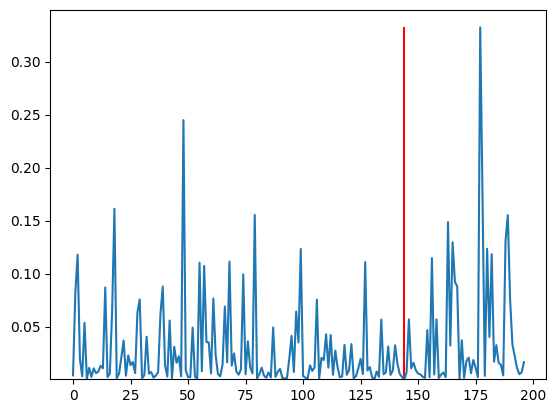

In [12]:
y_max, y_min = max(lst),min(lst)
plt.plot(lst)
plt.bar(x=lst.index(y_min),bottom=y_min,height=(y_max-y_min),color="r")

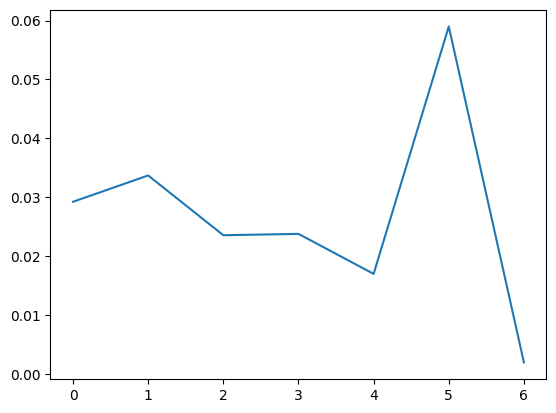

In [28]:
plt.plot(list(map(lambda o: sum(lst[(o*BATCH_SIZE):((o+1)*BATCH_SIZE)])/BATCH_SIZE, range(int(np.ceil(len(lst)/BATCH_SIZE))))))

In [13]:
len(model_snapshot)

197

In [14]:
model_best = model_snapshot[lst.index(y_min)]
model_final = model_snapshot[-1]

In [15]:
torch.save(model_best,"snapshots/resnet34_best01.pt")
torch.save(model_final,"snapshots/resnet34_final01.pt")